In [1]:
# Reading Data
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('all')

# Data Preprocessing
import re, nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Building Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalAveragePooling1D
import tensorflow.keras as k

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [2]:
# Mounting the drive, to import/read files from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing the Training and Testing Data
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/train.csv')
df_sm = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/Sarcasm_Headlines_Dataset.json', lines=True)

In [4]:
# Looking at the Data
# Training Data
(df_train.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Sarcasm Data
(df_sm.head())

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
# Basic info of train data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
# Checking null values for train data
train_null = df_train.isnull().sum()
print(train_null)
print("*"*100)
if train_null.any():
  print("\nThere are null values in the Training Dataset.")
else:
  print("There are no Null values in the Training Dataset")
  print(f"\tThe shape of the training data is, {df_train.shape}, with \n\t\t {df_train.shape[0]} rows, and,\n\t\t {df_train.shape[1]} features")

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
****************************************************************************************************
There are no Null values in the Training Dataset
	The shape of the training data is, (159571, 8), with 
		 159571 rows, and,
		 8 features


In [9]:
targets = list(df_train.columns[2:])
df_targets = df_train[targets].copy()

# How many rows are toxic?
nontoxic_rows = df_targets.sum(axis=1)
nontoxic_rows = (nontoxic_rows == 0)

# Create overall any_label feature
targets.append('Clean')
df_targets['Clean'] = nontoxic_rows

count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts

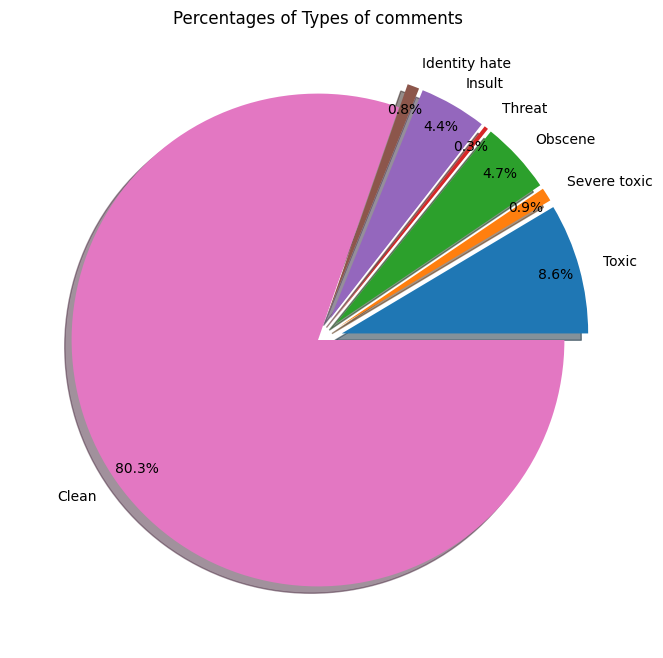

In [12]:
totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])

# Plotting the above details in a pie chart
labels=["Toxic", "Severe toxic", "Obscene", "Threat", "Insult", "Identity hate", "Clean"]
plt.figure(figsize=[8,8])
plt.title("Percentages of Types of comments")
plt.pie(totals,labels = labels, autopct="%1.1f%%", pctdistance=0.9, shadow=True, explode=[0.1,0.1,0.1,0.1,0.1,0.1,0])
plt.show()

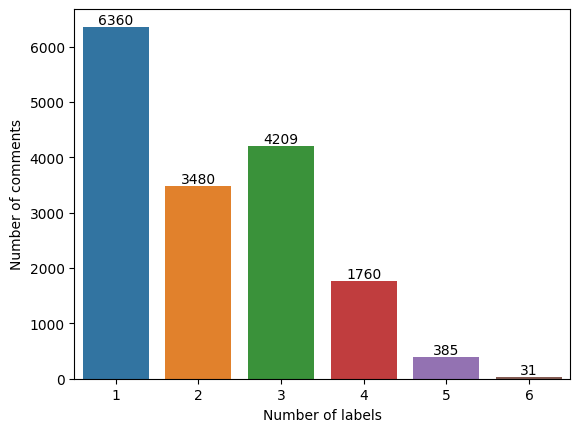

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# Comments with multiple labels
rowSums = df_train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("Number of labels",fontsize=10)
plt.ylabel("Number of comments",fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

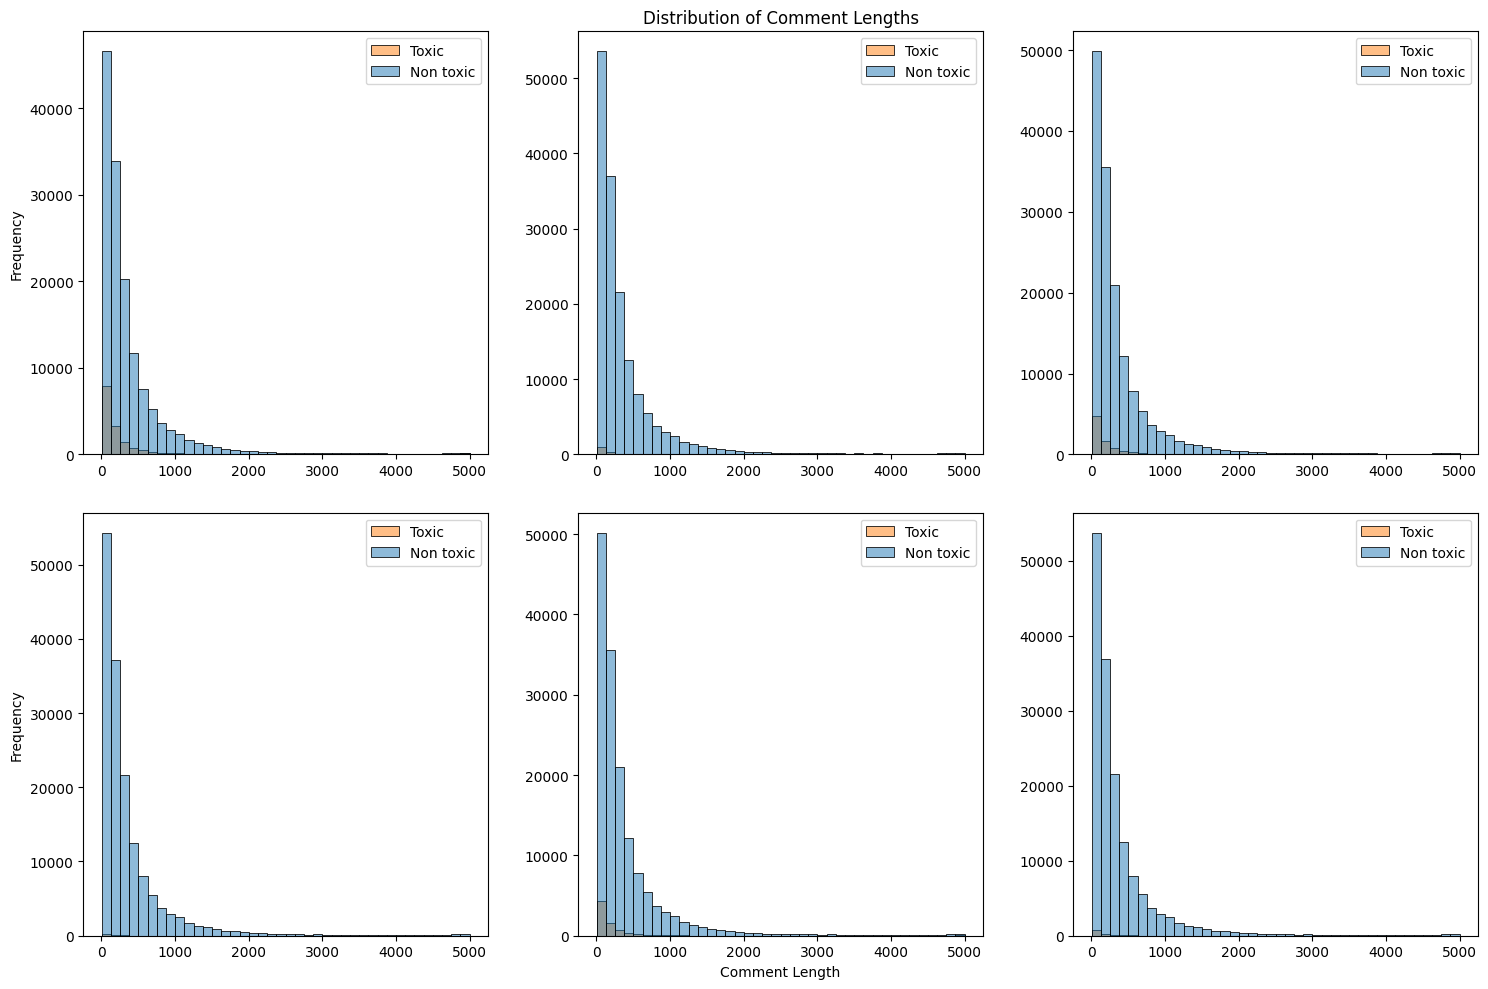

In [15]:
# Plotting Comment Lengths

df_train.comment_length=df_train.comment_text.apply(len)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
legend=["Toxic","Non toxic"]
# Plot x1 six times with different data
x1 = sns.histplot(data=df_train, x=df_train.comment_length, hue='toxic', bins=40, ax=axs[0])
axs[0].set_xlabel(' ')
axs[0].set_ylabel('Frequency')
axs[0].legend(legend,fontsize=10)

x2 = sns.histplot(data=df_train, x=df_train.comment_length, hue='severe_toxic', bins=40, ax=axs[1])
axs[1].set_xlabel(' ')
axs[1].set_title(f'Distribution of Comment Lengths')
axs[1].set_ylabel(' ')
axs[1].legend(legend,fontsize=10)

x3 = sns.histplot(data=df_train, x=df_train.comment_length, hue='obscene', bins=40, ax=axs[2])
axs[2].set_xlabel(' ')
axs[2].set_ylabel(' ')
axs[2].legend(legend, fontsize=10)

x4 = sns.histplot(data=df_train, x=df_train.comment_length, hue='threat', bins=40, ax=axs[3])
axs[3].set_xlabel(' ')
axs[3].set_ylabel('Frequency')
axs[3].legend(legend,fontsize=10)

x5 = sns.histplot(data=df_train, x=df_train.comment_length, hue='insult', bins=40, ax=axs[4])
axs[4].set_xlabel('Comment Length')
axs[4].set_ylabel(' ')
axs[4].legend(legend, fontsize=10)

x6 = sns.histplot(data=df_train, x=df_train.comment_length, hue='identity_hate', bins=40, ax=axs[5])
axs[5].set_xlabel(' ')
axs[5].set_ylabel(' ')
axs[5].legend(legend,fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
# toxic_comments = df_train[df_train['toxic'] == 1]['comment_text'].str.lower().str.split()
non_toxic_comments = df_train[df_train['toxic'] == 0]['comment_text'].str.lower().str.split()

In [ ]:
# Importing images for wordcloud masks
from google.colab import files
uploaded = files.upload()

Saving sm.jpg to sm (1).jpg
Saving clean.jpg to clean.jpg
Saving idhate1.jpg to idhate1.jpg
Saving ang.jpg to ang.jpg
Saving bmb.jpg to bmb.jpg
Saving obs1.jpg to obs1.jpg
Saving sevtxic3.jpg to sevtxic3.jpg
Saving txic2.jpg to txic2.jpg


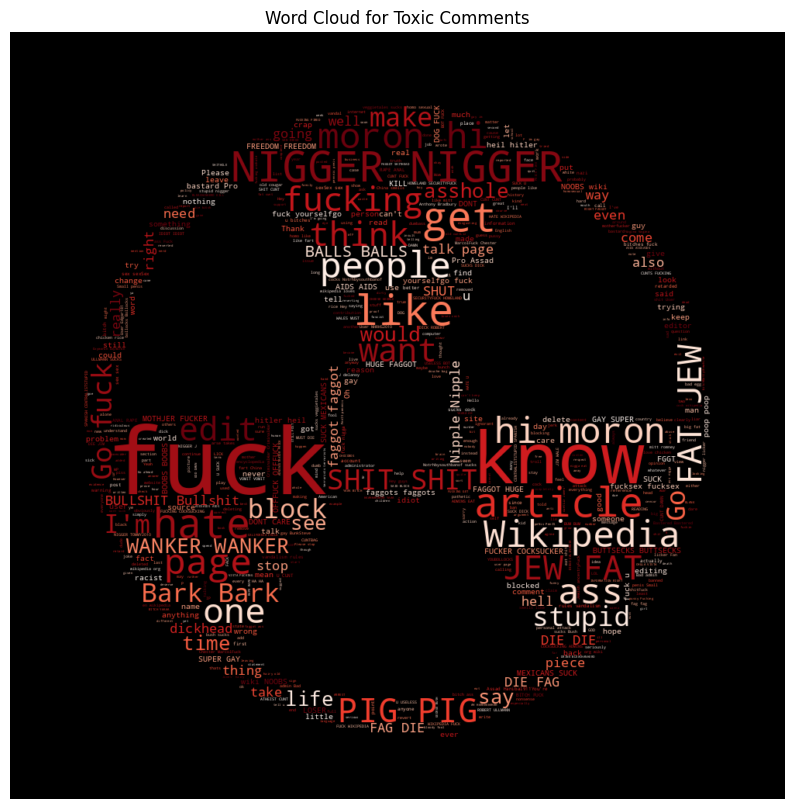

In [ ]:
# Wordcloud for toxic comments
# Extracting toxic words
toxicwrd = df_train[df_train.toxic==1]
toxicwrd = toxicwrd.comment_text.values
from PIL import Image
img1="txic2.jpg"
toxicimg = np.array(Image.open(img1))
# Building the wordcloud from the extracted toxic comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=toxicimg,
    max_words = 1000,
    colormap="Reds")
wc.generate(" ".join(toxicwrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Toxic Comments')
plt.axis('off')
plt.show()

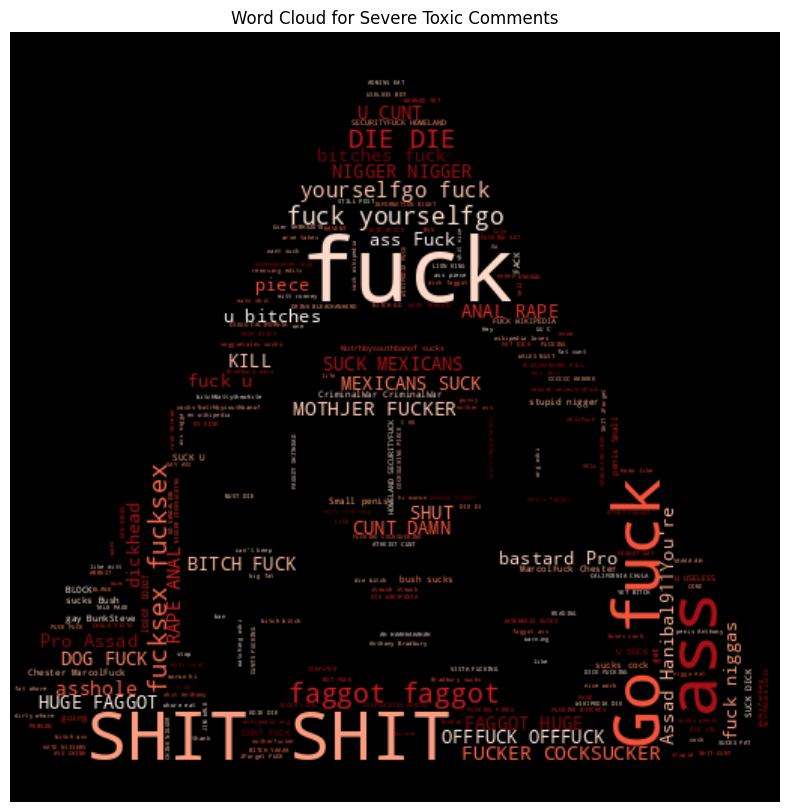

In [ ]:
# Wordcloud for severe toxic comments
# Extracting severe toxic words
sevtoxicwrd = df_train[df_train.severe_toxic==1]
sevtoxicwrd = sevtoxicwrd.comment_text.values
from PIL import Image
img2="sevtxic3.jpg"
sevtoxicimg = np.array(Image.open(img2))
# Building the wordcloud from the extracted severe toxic comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=sevtoxicimg,
    max_words = 1000,
    colormap="Reds")
wc.generate(" ".join(sevtoxicwrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Severe Toxic Comments')
plt.axis('off')
plt.show()

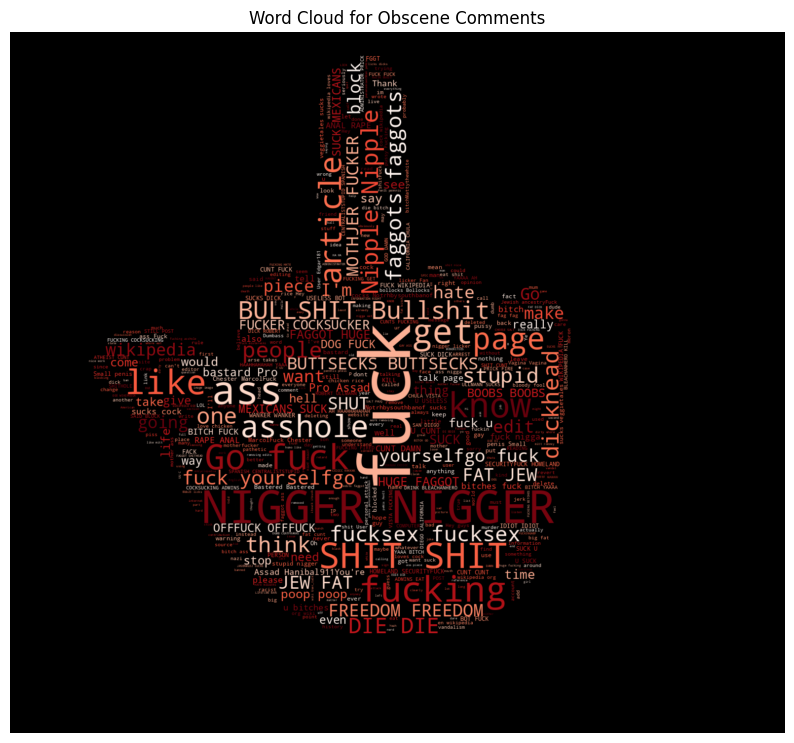

In [ ]:
# Wordcloud for obscene comments
# Extracting obscene words
obscenewrd = df_train[df_train.obscene==1]
obscenewrd = obscenewrd.comment_text.values
from PIL import Image
img3="obs1.jpg"
obs_img = np.array(Image.open(img3))
# Building the wordcloud from the extracted obscene comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=obs_img,
    max_words = 1000,
    colormap="Reds")
wc.generate(" ".join(obscenewrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Obscene Comments')
plt.axis('off')
plt.show()

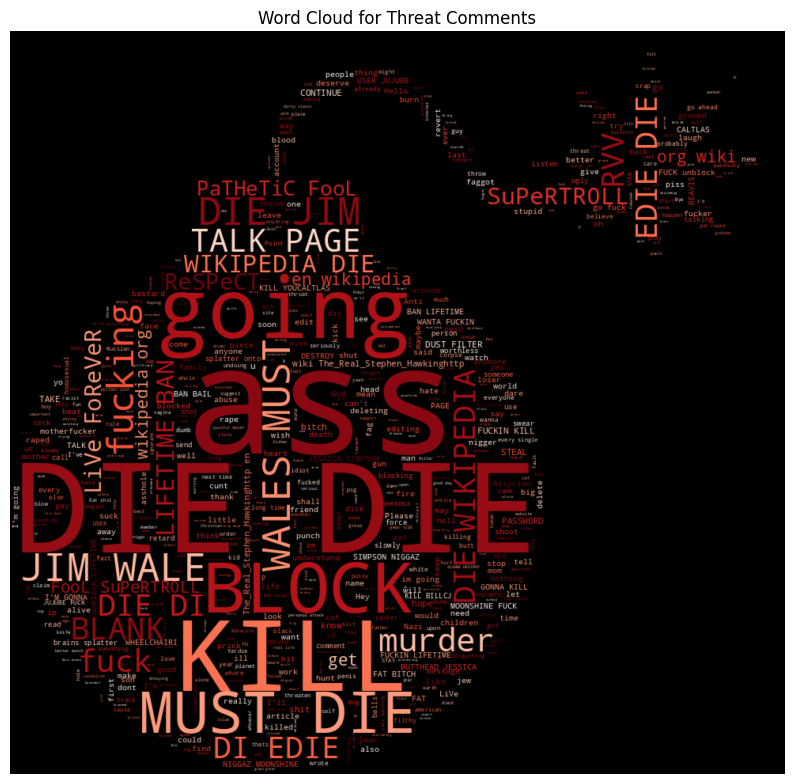

In [ ]:
# Wordcloud for threat comments
# Extracting threat words
threatwrd = df_train[df_train.threat==1]
threatwrd = threatwrd.comment_text.values
from PIL import Image
img4="bmb.jpg"
threatimg = np.array(Image.open(img4))
# Building the wordcloud from the extracted threat comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=threatimg,
    max_words = 1000,
    colormap="Reds")
wc.generate(" ".join(threatwrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Threat Comments')
plt.axis('off')
plt.show()

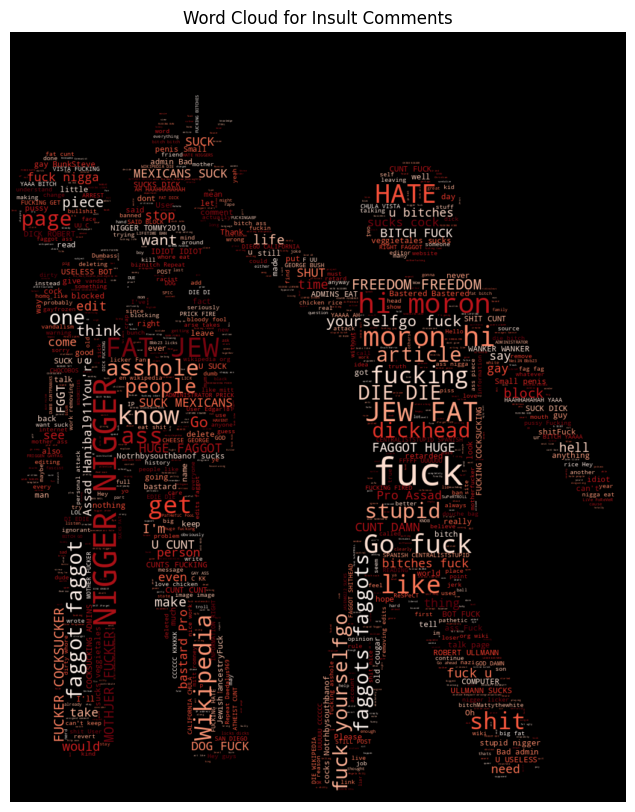

In [ ]:
# Wordcloud for insult comments
# Extracting insult words
insultwrd = df_train[df_train.insult==1]
insultwrd = insultwrd.comment_text.values
from PIL import Image
img5="ang.jpg"
insultimg = np.array(Image.open(img5))
# Building the wordcloud from the extracted insult comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=insultimg,
    max_words = 1000,
    colormap="Reds")
wc.generate(" ".join(insultwrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Insult Comments')
plt.axis('off')
plt.show()

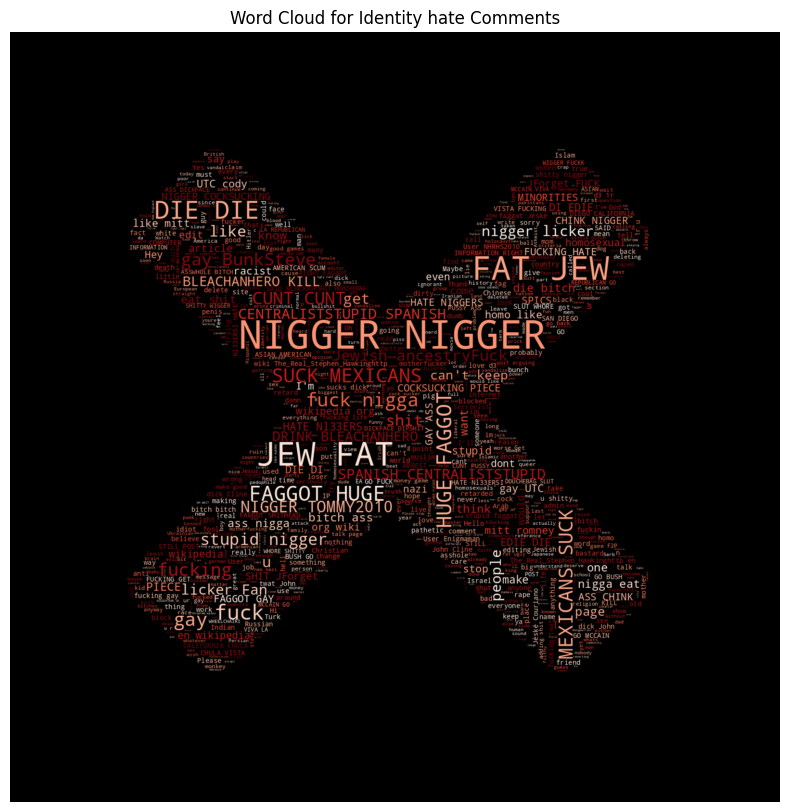

In [ ]:
# Wordcloud for identity hate comments
# Extracting identity hate words
idhatewrd = df_train[df_train.identity_hate==1]
idhatewrd = idhatewrd.comment_text.values
from PIL import Image
img6="idhate1.jpg"
idhateimg = np.array(Image.open(img6))
# Building the wordcloud from the extracted identity hate comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=idhateimg,
    max_words = 1000,
    colormap="Reds")
wc.generate(" ".join(idhatewrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Identity hate Comments')
plt.axis('off')
plt.show()

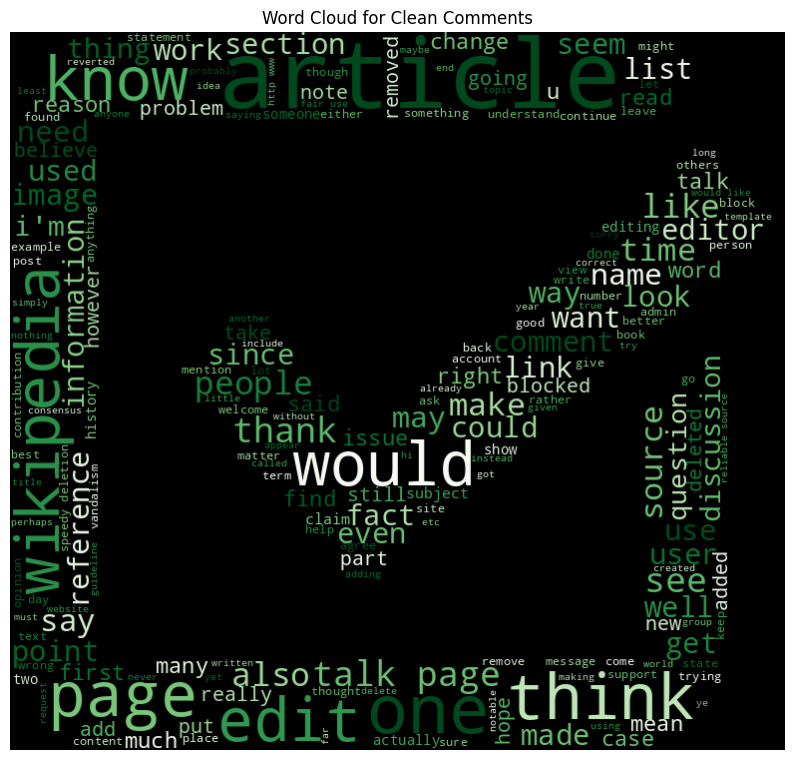

In [ ]:
# Wordcloud for clean comments
# Extracting clean words
img7="clean.jpg"
clean_img = np.array(Image.open(img7))
# Building the wordcloud from the extracted clean comment texts
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 600,
    width = 400,
    mask=clean_img,
    colormap="Greens")
wc.generate(' '.join([word for comment in non_toxic_comments for word in comment]))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Clean Comments')
plt.axis('off')
plt.show()

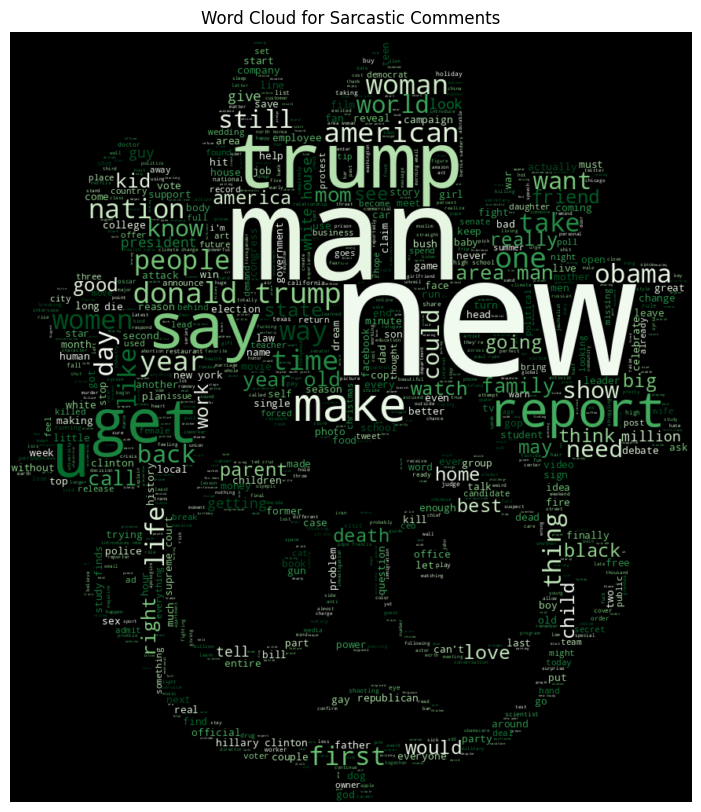

In [ ]:
# Wordcloud for sarcastic comments
# Extracting words from the sarcasm dataset
from PIL import Image
img8="sm.jpg"
smimg = np.array(Image.open(img8))
smwrd = df_sm["headline"].values
# Building the wordcloud from the extracted sarcastic comments
wc = WordCloud(
    background_color = 'black',
    stopwords = stop_words,
    height = 360,
    width = 360,
    mask=smimg,
    max_words = 1000,
    colormap="Greens")
wc.generate(" ".join(smwrd))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Sarcastic Comments')
plt.axis('off')
plt.show()

In [ ]:
# Creating a NEW Column for testing some things
d1 = df_train
d1["TEST"] = d1['toxic'] + d1['severe_toxic'] + d1['obscene'] + d1['threat'] + d1['insult'] + d1['identity_hate']
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   TEST           159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


<H1> Machine Learning Models Below -</H1>

<H2> Preprocessing, Cleaning & Tokenizing the Comments -</H2>


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Creating a function to Prepross all the Comments
def preprocess_comment(comment):
    # Making the comment lower case
    comment = comment.lower()

    # Using the preprocessor library to clean Twitter-specific elements like - mentions, hashtags, URLs
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)

    # Removing special characters and numbers
    comment = re.sub(r'[^a-zA-Z\s]', '', comment)

    # Removeing numbers and special characters
    comment = re.sub(r'\d+', '', comment)
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(comment)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Reassemble the cleaned tokens into a string
    text = ' '.join(tokens)

    # Stemming
    stemmer = nltk.SnowballStemmer("english")
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')]

    # Reassemble the cleaned tokens into a string
    cleaned_comment = ' '.join(text)

    return cleaned_comment

In [18]:
# Loading the Data Again
df_train_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/train.csv')
#df_test_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/test.csv')

# Cleaning Comments for Trainng and Testing Data
df_train = df_train_ori
#df_test = df_test_ori

df_train['comment_text'] = df_train_ori['comment_text'].apply(preprocess_comment)
#df_test['comment_text'] = df_test_ori['comment_text'].apply(preprocess_comment)


In [19]:
# Identifying the labels, the target data, and updating the df_train to remove the labels
targets = list(df_train.columns[2:])
df_targets = df_train[targets].copy()

df_train = df_train.drop(columns = targets)

# Looking at the Processed Data
df_train.head()

,id,comment_text
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...
3,0001b41b1c6bb37e,cant make real suggest improv wonder section s...
4,0001d958c54c6e35,sir hero chanc rememb page that


In [20]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [21]:
df_targets.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [22]:
# Vectorizing the Comments

t_comms = df_train
comment_vector = TfidfVectorizer(max_features=10000, analyzer='word', #ngram_range=(2, 6),
                                 stop_words='english')

training_comments = comment_vector.fit_transform(t_comms.comment_text)

# Splitting the Training set into Train & Validation data, the split is 80-20%
X_train, X_val, Y_train, Y_val = train_test_split(training_comments, df_targets, test_size=0.2, random_state=42)

print(f'The shape of the Training Data is - {X_train.shape}')
print(f'The shape of the Training Labels is - {Y_train.shape}')
print(f'\nThe shape of the Validation Data is - {X_val.shape}')
print(f'The shape of the Validation Labels is - {Y_val.shape}')
print(f'\nThe shape of the Testing Data is - {df_test.shape}')

# Combining the 6 classifiers into 1 - 'Combined' column
Y_train["Combined"] = Y_train['toxic'] + Y_train['severe_toxic'] + Y_train['obscene'] + Y_train['threat'] + Y_train['insult'] + Y_train['identity_hate']

Y_val["Combined"] = Y_val['toxic'] + Y_val['severe_toxic'] + Y_val['obscene'] + Y_val['threat'] + Y_val['insult'] + Y_val['identity_hate']

The shape of the Training Data is - (127656, 10000)
The shape of the Training Labels is - (127656, 6)

The shape of the Validation Data is - (31915, 10000)
The shape of the Validation Labels is - (31915, 6)

The shape of the Testing Data is - (153164, 2)


In [23]:
# # Looking at certain string in vectorized dataframe
# import pandas as pd
# feature_names = comment_vector.get_feature_names_out()

# dum = pd.DataFrame(feature_names)
# #print(feature_names.columns.get_loc('fuck'))
# specific_string = 'dic'
# filtered_rows = dum[dum[0].str.startswith(specific_string)]
# print(f"Rows where 'Name' starts with '{specific_string}':")
# print(filtered_rows)
# #dum.iloc[100:200]

<H1>Logistic Regression</H1>

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn. metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

logreg_models ={}

log_reg_metrics_table = pd.DataFrame(columns=['Label', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for classes in Y_train.columns.tolist():

  Y_train_lr = Y_train[classes]
  Y_val_lr = Y_val[classes]
  # Creating and training the Logistic Regression model
  logreg_model = LogisticRegression(max_iter=500, solver='lbfgs', random_state=42)
  logreg_model.fit(X_train, Y_train_lr)

  # Make predictions on the test set
  y_pred = logreg_model.predict(X_val)

  # Evaluating the model
  val_accuracy = accuracy_score(Y_val_lr, y_pred)
  val_precision = precision_score(Y_val_lr, y_pred, average='weighted')
  val_recall = recall_score(Y_val_lr, y_pred, average='weighted')
  val_f1 = f1_score(Y_val_lr, y_pred, average='weighted')

  # Save metrics in the DataFrame
  log_reg_metrics_table = log_reg_metrics_table.append({
        'Label': classes,
        'Accuracy': val_accuracy,
        'Precision': val_precision,
        'Recall': val_recall,
        'F1 Score': val_f1
    }, ignore_index=True)

  # Saving the models
  logreg_models[classes] = logreg_model

# Printing the Model Performance
print("Scores for Labels are -")
log_reg_metrics_table

Scores for Labels are -


,Label,Accuracy,Precision,Recall,F1 Score
0,toxic,0.956917,0.955139,0.956917,0.953232
1,severe_toxic,0.990318,0.987869,0.990318,0.988546
2,obscene,0.976688,0.975581,0.976688,0.974604
3,threat,0.997807,0.997129,0.997807,0.997101
4,insult,0.968855,0.965713,0.968855,0.965282
5,identity_hate,0.991665,0.989695,0.991665,0.989003
6,Combined,0.918346,0.892815,0.918346,0.902158


In [26]:
# Testing the Prediction for Logistic Regression

# Assume you have a new comment stored in a variable 'new_comment'
new_comment = "You should keep fucking gay yourself."

# Preprocessing the new comment
preprocessed_comment = preprocess_comment(new_comment)  # Use your preprocessing function

# Vectorizing the new comment using the same TF-IDF vectorizer
new_comment_vec = comment_vector.transform([preprocessed_comment])

# Making predictions for each toxicity label
predictions = {}
for toxicity_label in Y_train.columns:
    logreg_model = logreg_models[toxicity_label]
    prediction = logreg_model.predict(new_comment_vec)
    predictions[toxicity_label] = prediction[0]

# Display the predictions
print("Predictions for the new comment:")

for toxicity_label, prediction in predictions.items():
   print(f"{toxicity_label}: {prediction}")


Predictions for the new comment:
toxic: 1
severe_toxic: 1
obscene: 1
threat: 0
insult: 1
identity_hate: 1
Combined: 4


<H1>Random Forest</H1>

In [27]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rand_forest_models = {}

rf_reg_metrics_table = pd.DataFrame(columns=['Label', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for classes in Y_train.columns.tolist():

  Y_train_rf = Y_train[classes]
  Y_val_rf = Y_val[classes]

  # Build and train the Random Forest model
  rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_model.fit(X_train, Y_train_rf)

  # Make predictions on the test set
  y_pred = rf_model.predict(X_val)

  # Evaluating the model
  val_accuracy = accuracy_score(Y_val_rf, y_pred)
  val_precision = precision_score(Y_val_rf, y_pred, average='weighted')
  val_recall = recall_score(Y_val_rf, y_pred, average='weighted')
  val_f1 = f1_score(Y_val_rf, y_pred, average='weighted')

  # Save metrics in the DataFrame
  rf_reg_metrics_table = rf_reg_metrics_table.append({
        'Label': classes,
        'Accuracy': val_accuracy,
        'Precision': val_precision,
        'Recall': val_recall,
        'F1 Score': val_f1
    }, ignore_index=True)

  # Saving the models
  rand_forest_models[classes] = rf_model

# Printing the Model Performance
print("Scores for Labels are -")
rf_reg_metrics_table

Scores for Labels are -


,Label,Accuracy,Precision,Recall,F1 Score
0,toxic,0.957167,0.954825,0.957167,0.954772
1,severe_toxic,0.989785,0.984885,0.989785,0.985807
2,obscene,0.977816,0.976591,0.977816,0.976733
3,threat,0.997744,0.996946,0.997744,0.996886
4,insult,0.968667,0.965782,0.968667,0.966444
5,identity_hate,0.991540,0.989675,0.991540,0.988514
6,Combined,0.917186,0.890688,0.917186,0.899107


In [28]:
# Testing the Prediction for Random Forest

# Assume you have a new comment stored in a variable 'new_comment'
new_comment = "You should keep fucking gay yourself."

# Preprocessing the new comment
preprocessed_comment = preprocess_comment(new_comment)  # Use your preprocessing function

# Vectorizing the new comment using the same TF-IDF vectorizer
new_comment_vec = comment_vector.transform([preprocessed_comment])

# Making predictions for each toxicity label
predictions = {}
for toxicity_label in Y_train.columns:
    rand_forest_model = rand_forest_models[toxicity_label]
    prediction = rand_forest_model.predict(new_comment_vec)
    predictions[toxicity_label] = prediction[0]

# Display the predictions
print("Predictions for the new comment:")

for toxicity_label, prediction in predictions.items():
   print(f"{toxicity_label}: {prediction}")


Predictions for the new comment:
toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 1
identity_hate: 0
Combined: 3


<H1>SVM</H1>

In [29]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

svm_models = {}

svm_metrics_table = pd.DataFrame(columns=['Label', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for classes in Y_train.columns.tolist():
    Y_train_svm = Y_train[classes]
    Y_val_svm = Y_val[classes]

    # Creating and training the SVM model
    svm_model = LinearSVC(C=1.0, random_state=42)
    svm_model.fit(X_train, Y_train_svm)

    # Make predictions on the validation set
    y_pred_svm = svm_model.predict(X_val)

    # Evaluating the model
    val_accuracy_svm = accuracy_score(Y_val_svm, y_pred_svm)
    val_precision_svm = precision_score(Y_val_svm, y_pred_svm, average='weighted')
    val_recall_svm = recall_score(Y_val_svm, y_pred_svm, average='weighted')
    val_f1_svm = f1_score(Y_val_svm, y_pred_svm, average='weighted')

    # Save metrics in the DataFrame
    svm_metrics_table = svm_metrics_table.append({
        'Label': classes,
        'Accuracy': val_accuracy_svm,
        'Precision': val_precision_svm,
        'Recall': val_recall_svm,
        'F1 Score': val_f1_svm
      }, ignore_index=True)

    # Saving the Models
    svm_models[classes] = svm_model

# Printing the Model Performance
print("Scores for Labels are -")
svm_metrics_table

Scores for Labels are -


,Label,Accuracy,Precision,Recall,F1 Score
0,toxic,0.959956,0.957962,0.959956,0.957811
1,severe_toxic,0.990412,0.988226,0.990412,0.988885
2,obscene,0.978192,0.977006,0.978192,0.976824
3,threat,0.997681,0.997026,0.997681,0.997223
4,insult,0.969763,0.966919,0.969763,0.967297
5,identity_hate,0.992292,0.990697,0.992292,0.990603
6,Combined,0.917970,0.893820,0.917970,0.903089


In [30]:
# Testing the Prediction for SVC

# Assuming you have a new comment stored in a variable 'new_comment'
new_comment = "You should keep fucking gay yourself."

# Preprocess the new comment
preprocessed_comment = preprocess_comment(new_comment)

# Vectorize the new comment using the same TF-IDF vectorizer
new_comment_vec = comment_vector.transform([preprocessed_comment])

# Make predictions for each toxicity label using the respective logistic regression model
predictions = {}
for toxicity_label in Y_train.columns:
    svm_model = svm_models[toxicity_label]
    prediction = svm_model.predict(new_comment_vec)
    predictions[toxicity_label] = prediction[0]

# Display the predictions
print("Predictions for the new comment:")

for toxicity_label, prediction in predictions.items():
   print(f"{toxicity_label}: {prediction}")

Predictions for the new comment:
toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 1
identity_hate: 1
Combined: 4


<H1>Toxic Comment Neural Network</H1>

In [31]:
# Loading the Data Again
df_train_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/train.csv')
# df_test_ori = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/test.csv')

# Cleaning Comments
data = df_train_ori
data['comment_text'] = data['comment_text'].apply(preprocess_comment)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggest improv wonder section s...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page that,0,0,0,0,0,0


In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import tensorflow.keras as k
import pandas as pd

label_columns = ["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]

# Tokenization
tokenizer = Tokenizer(oov_token="<oov>")
tokenizer.fit_on_texts(data['comment_text'])
word_idx = tokenizer.word_index

# Text to sequence
data_sequence = tokenizer.texts_to_sequences(data['comment_text'])

# Padding sequences
pad_seq = pad_sequences(data_sequence, padding="pre", truncating="pre")

print(f"The Padding Sequence is - {pad_seq.shape}")


The Padding Sequence is - (159571, 1250)


In [33]:
# Determining the input length and vocabulary size
input_length = pad_seq.shape[1]
vocabulary_size = len(word_idx) + 1

# Spliting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(pad_seq, data[label_columns].values, train_size=0.7, random_state=42)

# Building a simple sequential model
model = Sequential([
    Embedding(vocabulary_size, 50, input_length=input_length),
    GlobalAveragePooling1D(),
    Dense(48, activation="relu"),
    Dense(6, activation="sigmoid")  # 6 output neurons for 6 label columns with sigmoid activation for multi-label classification
])

# Compiling the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Training the model to classify toxic comments
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=2)

Epoch 1/5
3491/3491 - 131s - loss: 0.1469 - accuracy: 0.9555 - val_loss: 0.1296 - val_accuracy: 0.9940 - 131s/epoch - 38ms/step
Epoch 2/5
3491/3491 - 34s - loss: 0.1116 - accuracy: 0.9942 - val_loss: 0.0985 - val_accuracy: 0.9940 - 34s/epoch - 10ms/step
Epoch 3/5
3491/3491 - 28s - loss: 0.0856 - accuracy: 0.9942 - val_loss: 0.0850 - val_accuracy: 0.9940 - 28s/epoch - 8ms/step
Epoch 4/5
3491/3491 - 29s - loss: 0.0724 - accuracy: 0.9942 - val_loss: 0.0763 - val_accuracy: 0.9940 - 29s/epoch - 8ms/step
Epoch 5/5
3491/3491 - 24s - loss: 0.0643 - accuracy: 0.9942 - val_loss: 0.0671 - val_accuracy: 0.9940 - 24s/epoch - 7ms/step


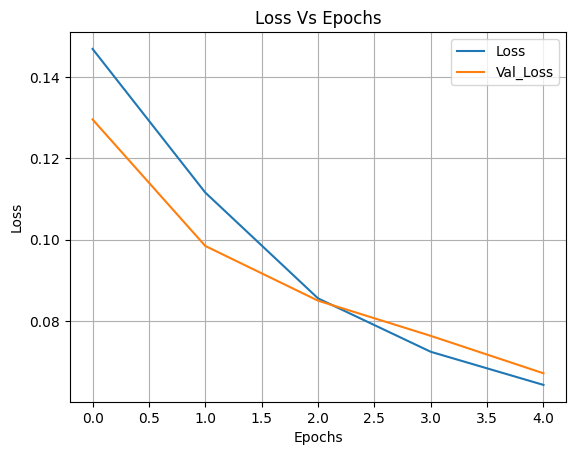

In [34]:
# Plotting Loss vs Epochs
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss Vs Epochs")

plt.legend()
plt.grid()

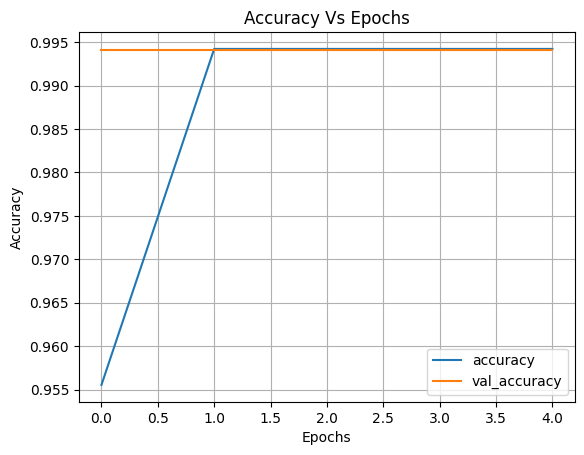

In [35]:
# Plotting Accuracy vs Epochs
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Accuracy Vs Epochs")

plt.legend()
plt.grid()

In [36]:
# Testing the Neural Network Model

# User input
user_input = "You should keep fucking gay yourself."

# Tokenize and pad the user input
user_sequence = tokenizer.texts_to_sequences([user_input])
user_padded = pad_sequences(user_sequence, padding="pre", truncating="pre", maxlen=input_length)

# Make the prediction
prediction = model.predict(user_padded)

# Display the predicted labels for each column
predicted_labels = (prediction > 0.1).astype(int)
column_names = ["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]

print("Predicted Labels:")
for i, col in enumerate(column_names):
    print(f"{col}: {predicted_labels[0][i]}")

1/1 [==============================] - 0s 250ms/step
Predicted Labels:
toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 1
identity_hate: 0


## LSTM

Epoch 1/5
6981/6981 [==============================] - 780s 110ms/step - loss: 0.0702 - accuracy: 0.9871 - val_loss: 0.0573 - val_accuracy: 0.9940
Epoch 2/5
6981/6981 [==============================] - 698s 100ms/step - loss: 0.0572 - accuracy: 0.9934 - val_loss: 0.0598 - val_accuracy: 0.9940
Epoch 3/5
6981/6981 [==============================] - 693s 99ms/step - loss: 0.0543 - accuracy: 0.9942 - val_loss: 0.0549 - val_accuracy: 0.9941
Epoch 4/5
6981/6981 [==============================] - 700s 100ms/step - loss: 0.0514 - accuracy: 0.9938 - val_loss: 0.0550 - val_accuracy: 0.9941
Epoch 5/5
997/997 [==============================] - 43s 40ms/step - loss: 0.0581 - accuracy: 0.9939
Test Accuracy: 99.39%


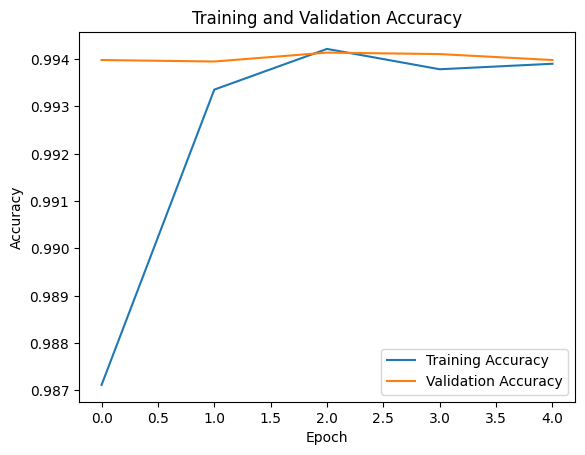

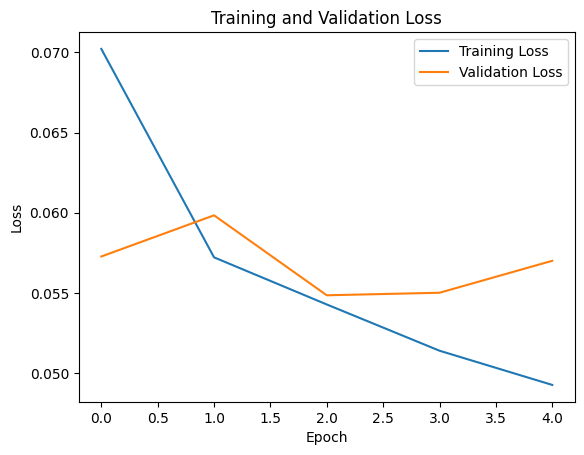

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/train.csv') #pd.read_csv('/content/drive/MyDrive/train.csv')
X = df['comment_text']
y = df[df.columns[2:]].values

# Text vectorization
MAX_FEATURES = 2000  # Number of words in the vocab
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=1800,
    output_mode='int'
)
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(1600)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

# Split the dataset into train, validation, and test sets
train = dataset.take(int(len(dataset) * 0.7))
val = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

# Build the model
model = Sequential()
model.add(Embedding(MAX_FEATURES + 1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=5, validation_data=val)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
# Save the model
model.save('toxicity_model.h5')

# User input for classification
user_input = "You should keep fucking gay yourself."

# Preprocess the user input
user_input_seq = vectorizer(np.array([user_input]))  # Use the same vectorizer
user_input_seq = np.squeeze(user_input_seq)  # Remove singleton dimension
user_input_seq = tf.expand_dims(user_input_seq, axis=0)  # Add batch dimension

# Make predictions using the loaded model
predictions = model.predict(user_input_seq)

# Display the predicted labels for each column
predicted_labels = (predictions > 0.3).astype(int)  # Assuming a threshold of 0.5
column_names = ["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]

print("Predicted Labels:")
for i, col in enumerate(column_names):
    print(f"{col}: {predicted_labels[0][i]}")

# Display the predictions
print("Predictions:")
print(predictions)

1/1 [==============================] - 0s 89ms/step
Predicted Labels:
toxic: 1
severe_toxic: 1
obscene: 1
threat: 0
insult: 1
identity_hate: 0
Predictions:
[[0.99977785 0.33127162 0.9635131  0.05312012 0.9363024  0.23486301]]


<H1> Sarcasm Detector</H1>

In [32]:
# Loading the Dataset
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Data_Mining_Project/Sarcasm_Headlines_Dataset.json', lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [33]:
# Function to Pre-Process the data
import re, nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# For Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalAveragePooling1D
import tensorflow.keras as k

punc = list(string.punctuation)
stop_words = stopwords.words("english")
lemma = WordNetLemmatizer()

def Process(data):
    data.lower()

    data = " ".join([lemma.lemmatize(word) for word in word_tokenize(data) if ((word not in punc) and (word not in stop_words))])

    # Removing special characters
    data = re.sub("[^a-z]", " ", data)

    # Using the preprocessor library to clean Twitter-specific elements like - mentions, hashtags, URLs
    data = re.sub("http\S+|www\S+|https\S+", "", data, flags=re.MULTILINE)

    # Removing special characters and numbers
    data = re.sub("[^a-zA-Z\s]", "", data)

    # Removeing numbers and special characters
    data = re.sub("\d+", "", data)

    return data

In [34]:
# Processing the Data to Remove unwanted comments
data.drop(columns="article_link", axis=1, inplace=True)
data.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [35]:
# Processing the Label
label = to_categorical(data["is_sarcastic"], 2)
label[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [36]:
# Assiging the Data to the required labels
X = data["headline"]
Y = label

In [37]:
# Tokenizing the data
tokenize = Tokenizer(oov_token="<oov>")
tokenize.fit_on_texts(X)
word_idx = tokenize.word_index

data_seqence = tokenize.texts_to_sequences(X)
pad_seq = pad_sequences(data_seqence, padding="pre", truncating="pre")

print("The Padding Sequance Shape is  --> ", pad_seq.shape)

# Updating the Input_length, and Vocabulary size accoriding to the training data

input_length = max(len(seq) for seq in data_seqence)

vocabulary_size = len(word_idx) + 1

input_length, vocabulary_size

The Padding Sequance Shape is  -->  (26709, 40)


(40, 29658)

In [39]:
# Splitting the data into Train and Test Dataset into a 80% - 20% split
x_train, x_test, y_train, y_test = train_test_split(pad_seq, label, train_size=0.8)

# Building a simple sequential neural network
model_scar = k.models.Sequential([
    Embedding(vocabulary_size, 50, input_length=input_length),
    GlobalAveragePooling1D(),
    Dense(48, activation="relu"),
    Dense(2, activation="softmax")
])

# Compiling the Model
model_scar.compile(optimizer="adam", loss=k.losses.BinaryCrossentropy(), metrics=["accuracy"])

# Training the Model
history = model_scar.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), verbose=2)

Epoch 1/20
668/668 - 13s - loss: 0.5009 - accuracy: 0.7381 - val_loss: 0.3514 - val_accuracy: 0.8519 - 13s/epoch - 20ms/step
Epoch 2/20
668/668 - 5s - loss: 0.2501 - accuracy: 0.8993 - val_loss: 0.3313 - val_accuracy: 0.8605 - 5s/epoch - 8ms/step
Epoch 3/20
668/668 - 4s - loss: 0.1542 - accuracy: 0.9439 - val_loss: 0.3512 - val_accuracy: 0.8560 - 4s/epoch - 6ms/step
Epoch 4/20
668/668 - 3s - loss: 0.0970 - accuracy: 0.9689 - val_loss: 0.4080 - val_accuracy: 0.8525 - 3s/epoch - 5ms/step
Epoch 5/20
668/668 - 3s - loss: 0.0628 - accuracy: 0.9805 - val_loss: 0.4698 - val_accuracy: 0.8512 - 3s/epoch - 4ms/step
Epoch 6/20
668/668 - 4s - loss: 0.0392 - accuracy: 0.9885 - val_loss: 0.5478 - val_accuracy: 0.8448 - 4s/epoch - 6ms/step
Epoch 7/20
668/668 - 4s - loss: 0.0249 - accuracy: 0.9931 - val_loss: 0.6226 - val_accuracy: 0.8437 - 4s/epoch - 6ms/step
Epoch 8/20
668/668 - 3s - loss: 0.0155 - accuracy: 0.9961 - val_loss: 0.7283 - val_accuracy: 0.8330 - 3s/epoch - 4ms/step
Epoch 9/20
668/668 - 

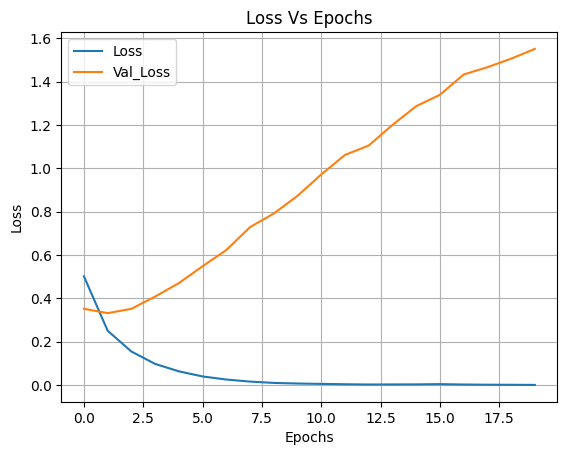

In [40]:
# Plotting the Loss Vs Epochs size
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss Vs Epochs")

plt.legend()
plt.grid()

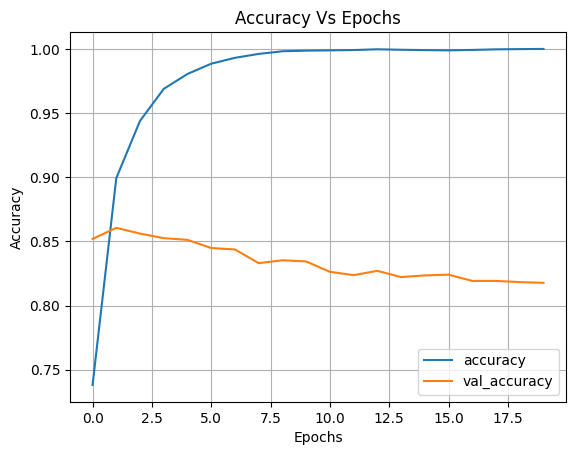

In [41]:
# Plotting the Accuracy Vs Epochs size
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Accuracy Vs Epochs")

plt.legend()
plt.grid()

In [44]:
# Testing the Model based on the Comment Input by the user
text = word_tokenize("Wow, your selfie brightened my day. I was desperately lacking in over-filtered perfection. Thank you for showing me the light.")

new_text = ""
for word in text:
    if (word not in stop_words) and (word not in punc):
        new_text += lemma.lemmatize(word)
        new_text += " "

print(new_text)
test_sequace = tokenize.texts_to_sequences([new_text])
test_padding = pad_sequences(test_sequace, maxlen=input_length, padding="pre", truncating="pre")


# test_sequace
prediction = model_scar.predict(test_padding)

print(prediction[0])
if np.argmax(prediction) == 0: print("This Comment is -->  is sarcastic ")
else: print("This Comment is -->  not sarcastic ")

Wow selfie brightened day I desperately lacking over-filtered perfection Thank showing light 
1/1 [==============================] - 0s 108ms/step
[9.9999893e-01 1.0307547e-06]
This Comment is -->  is sarcastic 
